þarf að laga events function þannig að það geti skilað kk og kvk events. Og skoða öll hin functions þ.a. þau séu þannig flex að ég get sett inn kk eða kvk eða bæði og fengið það sem ég vill

commenta hvað hvaða function er að gera

skoða milli ára breytingar á competitor_info

In [4]:
# for the data
import pandas as pd
import numpy as np
import requests
import re

# for plotting
import matplotlib.pyplot as plt

In [59]:
def games_json_dump(year=2022, division=1, page=1):
    """
    
    This function calls Crossfits webservice and returns json data on different years and divisions for the Crossfit Games
    Leaderboard.

    Parameters:
        - year from 2007 until most recent
        - division is either 1 for male or 2 for female
        - page is the number of page we are on the leaderboard

    """
    url = f"https://c3po.crossfit.com/api/leaderboards/v2/competitions/games/{year}/leaderboards?division={division}&sort=0&page={page}"
    #Sends the request and reads the response.
    response = requests.get(url)
    #Loads response as JSON
    response = response.json()
    return(response)

In [8]:
def games_info(year=2022, division=1):
    """
    
    This function calls Crossfits webservice and returns json data on different years and divisions for the Crossfit Games
    Leaderboard.

    Parameters:
        - year from 2007 until most recent
        - division is either 1 for male or 2 for female
        - page is the number of page we are on the leaderboard

    """
    # get the json data from the web service
    response = games_json_dump(year=year, division=division)
    
    # collecting data on the specified games session
    total_pages = response['pagination']['totalPages']
    total_competitors = response['pagination']['totalCompetitors']
    competition_id = response['competition']['competitionId']
    total_events = len(response['ordinals'])
    # return a list of responses
    games_info_list = [competition_id, total_pages, total_competitors, total_events]
    return(games_info_list)

In [9]:
# held að ég sé ekkert að nota þetta en mögulega gott að nota þetta til að byggja upp gagnamódelið
def games_info_multiple(year_from=2018, year_too=2022, division=1):
    
    """

    Parameters:
        - year_xxx is from 2007 and to current
        - division is 1 for male, 2 for female and 0 for both

    """
    
    # create a dataframe to store results
    df_games_info_multiple = pd.DataFrame(columns=['competitionId', 'totalPages', 'totalCompetitors', 'totalEvents', 'year','division'])
    # determining what division value we need
    if division.lower() == "male":
        division_value = [1]
    elif division.lower() == "female":
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]
    # iterate over year_from and year_too
    for i in range(0, year_too - year_from + 1):
        for j in range(0,len(division_value)):
            # results form running games_info funcation
            result_list = games_info(year_from+i,division=division_value[j])
            # results from function
            result_list.append(year_from+i)
            result_list.append(division_value[j])
            # Convert the list to a DataFrame with a single row
            temp_df = pd.DataFrame([result_list], columns=['competitionId', 'totalPages', 'totalCompetitors', 'totalEvents', 'year','division'])
            # Concatenate the DataFrame with the existing DataFrame
            df_games_info_multiple = pd.concat([df_games_info_multiple, temp_df], ignore_index=True)
    return(df_games_info_multiple)

In [10]:
df_games_info_multiple = games_info_multiple(2021,2022,"")
df_games_info_multiple.head()

,competitionId,totalPages,totalCompetitors,totalEvents,year,division
0,161,1,40,15,2021,1
1,161,1,40,15,2021,2
2,189,1,40,14,2022,1
3,189,1,40,14,2022,2


In [208]:
def games_info_competitors(year, division):
    
    """

    Parameters:
        - year is from 2007 and to current
        - division is 1 for male, 2 for female and 0 for both

    This functions get's a bitt more complicated when there are more than one pages per call,
    e.g. in the year 2019 when there were 144 male competitors.
    """
        
    # create a dataframe to store info
    df_games_info_competitors = pd.DataFrame()

    # determining what division value we need
    if division == 1:
        division_value = [1]
    elif division == 2:
        division_value = [2]
    # else we just take both divisions
    else:
        division_value = [1,2]

    # iterate over division_value
    for current_division in range(0,len(division_value)):
        # collecting data on the specified games session
        info_response = games_info(year=year,division=division_value[current_division])
        # iterate to solve for when pages are more than 1
        if info_response[1] > 1:
            for page in range(1, info_response[1] + 1):
                response = games_json_dump(year=year,division=division_value[current_division],page=page)
                if page == info_response[1]: # if we are on the final page
                    # call webservice to get get the json
                    response = games_json_dump(year=year,division=division_value[current_division],page=page)
                    for competitors_on_last_page in range(0, info_response[2] - (info_response[1] - 1) * 50): # there are currently 50 results per page
                        # parse json to where we want to be
                        entrant_json = response['leaderboardRows'][competitors_on_last_page]['entrant']
                        # insert results in temporary dataframe
                        df_temp = pd.DataFrame([entrant_json])
                        # concatenate the DataFrame with the existing DataFrame
                        df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
                else:
                    # call webservice to get get the json
                    response = games_json_dump(year=year,division=division_value[current_division],page=page)
                    for competitor_not_on_last_page in range(0,50): # there are currently 50 results per page
                        # parse json to where we want to be
                        entrant_json = response['leaderboardRows'][competitor_not_on_last_page]['entrant']
                        # insert results in temporary dataframe
                        df_temp = pd.DataFrame([entrant_json])
                        # concatenate the DataFrame with the existing DataFrame
                        df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
        else:
            # call webservice to get get the json
            response = games_json_dump(year=year,division=division_value[current_division],page=1)
            for competitor in range(0,info_response[2]):
                # parse json to where we want to be
                entrant_json = response['leaderboardRows'][competitor]['entrant']
                # insert results in temporary dataframe
                df_temp = pd.DataFrame([entrant_json])
                # Concatenate the DataFrame with the existing DataFrame
                df_games_info_competitors = pd.concat([df_games_info_competitors, df_temp], ignore_index=True)
    return(df_games_info_competitors)

In [209]:
a = games_info_competitors(2019,0)

In [210]:
a

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,countryShortCode,regionId,regionName,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain
0,153604,Mathew Fraser,Mathew,Fraser,ACT,,M,9e218-P153604_4-184.jpg,US,United States,,None,,1,3220,CrossFit Mayhem,29,67 in,195 lb,0
1,2725,Noah Ohlsen,Noah,Ohlsen,ACT,,M,0a0bc-P2725_5-184.jpg,US,United States,,None,,1,2509,Peak 360 CrossFit,28,67 in,190 lb,0
2,81616,Björgvin Karl Guðmundsson,Björgvin Karl,Guðmundsson,ACT,,M,4c5dc-P81616_4-184.jpg,IS,Iceland,,None,,1,4860,CrossFit Hengill,26,178 cm,190 lb,0
3,34796,Scott Panchik,Scott,Panchik,ACT,,M,e23e0-P34796_8-184.jpg,US,United States,,None,,1,7991,CrossFit Mentality,31,69 in,187 lb,0
4,16080,James Newbury,James,Newbury,ACT,,M,b7c6d-P16080_7-184.jpg,AU,Australia,,None,,1,5764,CrossFit Mode,28,177 cm,87 kg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,1218177,Cingiwe Ciegy Seru,Cingiwe Ciegy,Seru,CUT,,F,0f8c9-P1218177_1-184.jpg,BW,Botswana,,None,,2,19119,CrossFit Gaborone,35,160 cm,60 kg,0
271,1243131,Miriam Torra,Miriam,Torra,CUT,,F,996b1-P1243131_3-184.jpg,AD,Andorra,,None,,2,18437,La Borda CrossFit,25,168 cm,65 kg,0
272,1521928,Tamara Trumbetaš,Tamara,Trumbetaš,CUT,,F,3fad6-P1521928_2-184.jpg,RS,Serbia,,None,,2,None,,23,163 cm,65 kg,0
273,661943,Keshini Vitharana,Keshini,Vitharana,CUT,,F,823ae-P661943_1-184.jpg,LK,Sri Lanka,,None,,2,20562,CrossFit Ceylon,22,164 cm,60 kg,0


In [187]:
a['leaderboardRows'][30]['entrant']

{'competitorId': '889971',
 'competitorName': 'Melanie Yip Woon Sun',
 'firstName': 'Melanie',
 'lastName': 'Yip Woon Sun',
 'status': 'CUT',
 'postCompStatus': '',
 'gender': 'F',
 'profilePicS3key': 'women-square.jpg',
 'countryOfOriginCode': 'MU',
 'countryOfOriginName': 'Mauritius',
 'countryShortCode': '',
 'regionId': 'None',
 'regionName': '',
 'divisionId': '2',
 'affiliateId': '5735',
 'affiliateName': 'UPT CrossFit',
 'age': '33',
 'height': '165 cm',
 'weight': '77 kg',
 'teamCaptain': '0'}

In [156]:
# held að ég sé ekkert að nota þetta en mögulega gott að nota þetta til að byggja upp gagnamódelið
def games_info_competitor_multiple(year_from=2018, year_too=2022, division=1):
        
    # create a dataframe to store info
    df_games_info_competitor_multiple = pd.DataFrame()
    
    # iterate over the selected years
    for i in range(year_from, year_too + 1):
        df_temp = games_info_competitors(i,1)
        df_temp['year'] = i
        df_games_info_competitor_multiple = pd.concat([df_games_info_competitor_multiple, df_temp], ignore_index=True)
    
    return(df_games_info_competitor_multiple)

In [161]:
df_games_info_competitors[df_games_info_competitors['competitorName'] == 'Patrick Vellner']

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,...,regionId,regionName,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain,year
3,158264,Patrick Vellner,Patrick,Vellner,ACT,,M,d471c-P158264_7-184.jpg,CA,Canada,...,4,Canada East,1,None,,27,71 in,195 lb,0,2017
40,158264,Patrick Vellner,Patrick,Vellner,ACT,,M,d471c-P158264_7-184.jpg,CA,Canada,...,18,Canada East,1,6214,CrossFit Solid Ground,28,71 in,195 lb,0,2018
94,158264,Patrick Vellner,Patrick,Vellner,CUT,,M,d471c-P158264_7-184.jpg,CA,Canada,...,None,,1,6214,CrossFit Solid Ground,29,71 in,195 lb,0,2019
231,158264,Patrick Vellner,Patrick,Vellner,ACT,,M,d471c-P158264_7-184.jpg,CA,Canada,...,None,,1,1918,CrossFit Nanaimo,30,71 in,195 lb,0,2020


In [48]:
a = games_info_competitors(2017,1)
b = games_info_competitors(2020,1)

In [49]:
a.columns

Index(['competitorId', 'competitorName', 'firstName', 'lastName', 'status',
       'postCompStatus', 'gender', 'profilePicS3key', 'countryOfOriginCode',
       'countryOfOriginName', 'countryShortCode', 'regionId', 'regionName',
       'divisionId', 'affiliateId', 'affiliateName', 'age', 'height', 'weight',
       'teamCaptain'],
      dtype='object')

In [50]:
b.columns

Index(['competitorId', 'competitorName', 'firstName', 'lastName', 'status',
       'postCompStatus', 'gender', 'profilePicS3key', 'countryOfOriginCode',
       'countryOfOriginName', 'countryShortCode', 'regionId', 'regionName',
       'divisionId', 'affiliateId', 'affiliateName', 'age', 'height', 'weight',
       'teamCaptain'],
      dtype='object')

In [19]:
# Two functions to make height and weight comparable between US and rest of world

# function to convert inches to cm
def inch_to_cm(height):
    if 'in' in height:
        height_in_inches = float(height.replace('in', '').strip())
        return round(height_in_inches * 2.54, 1)
    else:
        return float(height.replace('cm', '').strip())

# function to convert lbs to kg
def lb_to_kg(weight):
    if 'lb' in weight:
        weight_in_lbs = float(weight.replace('lb', '').strip())
        return round(weight_in_lbs / 2.20462, 1)
    else:
        return float(weight.replace('kg', '').strip())

In [21]:
# apply the function to the 'Height' column and assign it back to the column
df_games_info_competitors['heightInCm'] = df_games_info_competitors['height'].apply(inch_to_cm)
df_games_info_competitors['weightInKg'] = df_games_info_competitors['weight'].apply(lb_to_kg)
# print the updated dataframe to see results
df_games_info_competitors.head(5)

,competitorId,competitorName,firstName,lastName,status,postCompStatus,gender,profilePicS3key,countryOfOriginCode,countryOfOriginName,...,regionName,divisionId,affiliateId,affiliateName,age,height,weight,teamCaptain,heightInCm,weightInKg
0,811708,Justin Medeiros,Justin,Medeiros,ACT,,M,672d4-P811708_4-184.jpg,US,United States,...,North America,1,1792,CrossFit Fort Vancouver,23,69 in,195 lb,0,175.3,88.5
1,975774,Roman Khrennikov,Roman,Khrennikov,ACT,,M,a2263-P975774_2-184.jpg,RU,,...,Asia,1,None,,27,182 cm,103 kg,0,182.0,103.0
2,40955,Ricky Garard,Ricky,Garard,ACT,,M,89cbe-P40955_10-184.jpg,AU,Australia,...,Oceania,1,None,,28,179 cm,200 lb,0,179.0,90.7
3,74320,Samuel Kwant,Samuel,Kwant,ACT,,M,a9afa-P74320_4-184.jpg,US,United States,...,North America,1,None,,26,71 in,206 lb,0,180.3,93.4
4,469656,Jeffrey Adler,Jeffrey,Adler,ACT,,M,e480e-P469656_1-184.jpg,CA,Canada,...,North America,1,18059,CrossFit Wonderland,28,69 in,197 lb,0,175.3,89.4


In [22]:
df_games_info_competitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   competitorId         40 non-null     object 
 1   competitorName       40 non-null     object 
 2   firstName            40 non-null     object 
 3   lastName             40 non-null     object 
 4   status               40 non-null     object 
 5   postCompStatus       40 non-null     object 
 6   gender               40 non-null     object 
 7   profilePicS3key      40 non-null     object 
 8   countryOfOriginCode  40 non-null     object 
 9   countryOfOriginName  40 non-null     object 
 10  countryShortCode     40 non-null     object 
 11  regionId             40 non-null     object 
 12  regionName           40 non-null     object 
 13  divisionId           40 non-null     object 
 14  affiliateId          40 non-null     object 
 15  affiliateName        40 non-null     objec

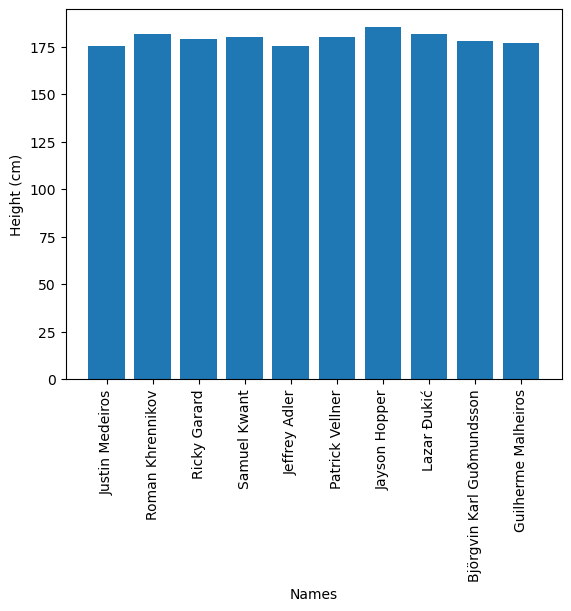

In [30]:
top10 = df_games_info_competitors.head(10)

# create a bar chart of the height data
plt.bar(top10['competitorName'], top10['heightInCm'],)

# add x-axis and y-axis labels
plt.xlabel('Names')
plt.ylabel('Height (cm)')

# rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

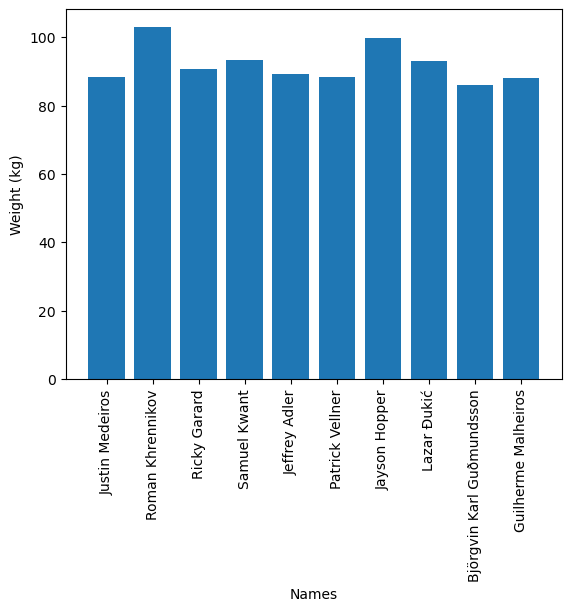

In [31]:
top10 = df_games_info_competitors.head(10)

# create a bar chart of the height data
plt.bar(top10['competitorName'], top10['weightInKg'],)

# add x-axis and y-axis labels
plt.xlabel('Names')
plt.ylabel('Weight (kg)')

# rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

In [291]:
def gamesInfoScores(year=2022, division=1):
    # create a dataframe to store the scores
    scoresDf = pd.DataFrame()
    # collecting data on the specified games session
    gamesInfoCall = gamesInfo(year=year,division=division)
    # determining what division value we need
    if division == 1:
        divisionValue = [1]
    elif division == 2:
        divisionValue = [2]
    # else we just take both divisions
    else:
        divisionValue = [1,2]
    
    for j in range(0,len(divisionValue)):
        # get the json data from the web service
        response = gamesJsonDump(year=year, division=divisionValue[j])
        for i in range(0, gamesInfoCall[2]):
            # results form running gamesInfo funcation
            scoresJson = response['leaderboardRows'][i]['scores']
            tempDf = pd.json_normalize(scoresJson)
            tempDf['competitorId'] = response['leaderboardRows'][i]['entrant']['competitorId']
            tempDf['division'] = divisionValue[j]
            # Concatenate the DataFrame with the existing DataFrame
            scoresDf = pd.concat([scoresDf, tempDf], ignore_index=True)
    # transformation of the data
    # some athletes got a DF score due to withdrawing from competiton before first event
    # if len(competitorData['overallScore']) < 1:
    #     df_cfgMales.loc[i,'overallScore'] = "0" 

    return(scoresDf)

SyntaxError: non-default argument follows default argument (581231218.py, line 1)

In [294]:
gamesInfoScores(2020,1)

,ordinal,rank,score,valid,scoreDisplay,scoreIdentifier,mobileScoreDisplay,scaled,video,heat,lane,breakdown,competitorId,division
0,1,1,100,1,3:08,fd69cb83976042a40b2f,,0,0,,,100 pts,153604,1
1,2,4,88,1,425 lb,c19135e3cd0bc7579764,,0,0,,,88 pts,153604,1
2,3,1,100,1,2:44,330d758bbd555ba25ecd,,0,0,,,100 pts,153604,1
3,4,8,72,1,2:55.20,388301719cfceaba4bc7,,0,0,,,72 pts,153604,1
4,5,1,100,1,17:50,48118b0d264137489e00,,0,0,,,100 pts,153604,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,16,,0,,,5e28fd0c71aeed055437,,0,0,,,,234569,1
596,17,,0,,,9b52a55b3e7c1f0a4985,,0,0,,,,234569,1
597,18,,0,,,e36ac94cf7efa29af66d,,0,0,,,,234569,1
598,19,,0,,,37a19dfa21ea4ff4c02c,,0,0,,,,234569,1


In [263]:
gamesInfo(2019,1)

[52, 3, 144, 12]

In [253]:
results = pd.merge(gamesInfoScoresFinal, competitorsInfo[['competitorId','competitorName']], on='competitorId')

In [255]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560 entries, 0 to 559
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ordinal             560 non-null    int64 
 1   rank                560 non-null    object
 2   score               560 non-null    object
 3   valid               560 non-null    object
 4   scoreDisplay        560 non-null    object
 5   scoreIdentifier     560 non-null    object
 6   mobileScoreDisplay  560 non-null    object
 7   scaled              560 non-null    object
 8   video               560 non-null    object
 9   heat                560 non-null    object
 10  lane                560 non-null    object
 11  breakdown           521 non-null    object
 12  competitorId        560 non-null    object
 13  competitorName      560 non-null    object
dtypes: int64(1), object(13)
memory usage: 65.6+ KB


In [259]:
# convert to numeric and check for NaN values
non_numeric = df[pd.to_numeric(df['scoreDisplay'], errors='coerce').isnull()]
non_numeric

,ordinal,rank,score,valid,scoreDisplay,scoreIdentifier,mobileScoreDisplay,scaled,video,heat,lane,breakdown
0,1,1,100,1,36:47.61,8cd42e7335a9f58c2c5c,,0,0,,,100 pts
1,2,2,97,1,06:58.74,47406f45a1013a3d1af7,,0,0,,,97 pts
2,3,3,94,1,16 rep,fc8ecef95523ddaa4fcb,,0,0,,,94 pts
3,4,5,88,1,5 pt,2991f049897ee92f2fd9,,0,0,,,88 pts
4,5,7,82,1,09:49.82,54c34a0f6157e81313d0,,0,0,,,82 pts
...,...,...,...,...,...,...,...,...,...,...,...,...
9,10,33,16,1,04:49.82,c9faee5905ac44a713a8,,0,0,,,16 pts
10,11,20,43,1,310 lb,4be1ee3a0ce29eaca7c3,,0,0,,,43 pts
11,12,31,0,,,2e71160ae2cfcffa9fcb,,0,0,,,NaN
12,13,30,0,,,ade47f11f203f75e4d19,,0,0,,,NaN
